In [1]:
import json
from prettytable import PrettyTable
import json
import os
import random
import pandas as pd

# Read the jsonl file and convert it to a JSON list
def jsonl_to_json_list(jsonl_file_path):
    json_list = []
    with open(jsonl_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            json_obj = json.loads(line.strip())  # Parse each line as JSON
            json_list.append(json_obj)
    
    return json_list

# Save the JSON list to a file
def save_as_json(json_list, output_file_path):
    with open(output_file_path, 'w', encoding='utf-8') as outfile:
        json.dump(json_list, outfile, indent=4)

def save_as_jsonl(json_list, output_file_path):
    with open(output_file_path, 'w', encoding='utf-8') as outfile:
        for json_obj in json_list:
            json.dump(json_obj, outfile)
            outfile.write('\n')

In [3]:
def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = [json.loads(line.strip()) for line in file]
    return data

def deduplicate_data(data):
    seen = set()
    deduplicated_data = []
    for item in data:
        idx = item['realidx']
        if idx not in seen:
            deduplicated_data.append(item)
            seen.add(idx)
    return deduplicated_data

def calculate_accuracy(data):
    correct_predictions = 0
    total_predictions = len(data)
    for item in data:
        if 'predicted_answer' not in item:
            print(item['realidx'])
        if item['answer_idx'] == item['predicted_answer']:
            correct_predictions += 1
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy

def calculate_cost_from_token_usage(data, model):
    total_cost = 0
    for item in data:
        if model == 'gpt-4o-mini':
            total_cost += item['token_usage']['prompt_tokens'] * 0.15 / 1000000 + item['token_usage']['completion_tokens'] * 0.6 / 1000000
        elif model == 'gpt-4o':
            total_cost += item['token_usage']['prompt_tokens'] * 2.5 / 1000000 + item['token_usage']['completion_tokens'] * 10 / 1000000
        elif model == 'o3-mini' or model == 'o1-mini':
            total_cost += item['token_usage']['prompt_tokens'] * 1.1 / 1000000 + item['token_usage']['completion_tokens'] * 4.4 / 1000000
        elif model == 'claude-3-5-sonnet':
            total_cost += item['token_usage']['prompt_tokens'] * 3.0 / 1000000 + item['token_usage']['completion_tokens'] * 15.0 / 1000000
        elif model == 'claude-3-5-haiku':
            total_cost += item['token_usage']['prompt_tokens'] * 0.8 / 1000000 + item['token_usage']['completion_tokens'] * 4.0 / 1000000
        elif model == 'QwQ-32B-Preview':
            total_cost += item['token_usage']['prompt_tokens'] * 1.2 / 1000000 + item['token_usage']['completion_tokens'] * 1.2 / 1000000
        elif model == 'DeepSeek-R1':
            total_cost += item['token_usage']['prompt_tokens'] * 7 / 1000000 + item['token_usage']['completion_tokens'] * 7 / 1000000
        elif model == 'DeepSeek-V3':
            total_cost += item['token_usage']['prompt_tokens'] * 1.25 / 1000000 + item['token_usage']['completion_tokens'] * 1.25 / 1000000
        elif model == 'Llama-3.3-70B-Instruct-Turbo':
            total_cost += item['token_usage']['prompt_tokens'] * 0.88 / 1000000 + item['token_usage']['completion_tokens'] * 0.88 / 1000000
    return total_cost / len(data)

def calculate_time_from_data(data):
    total_time = 0
    for item in data:
        total_time += item['time_elapsed']
    return total_time / len(data)

tasks = {
    'medqa': ['test'],
    'pubmedqa': ['test'],
    'medmcqa': ['test'],
    'medbullets': ['test'],
    'mmlu': ['test'],
    'mmlu-pro': ['test'],
    'afrimedqa': ['test'],
}
models = [
    'o3-mini',
    'gpt-4o-mini',
    'gpt-4o',
    'o1-mini',
    'QwQ-32B-Preview',
    'DeepSeek-R1',
    'Llama-3.3-70B-Instruct-Turbo',
    'DeepSeek-V3',
    'claude-3-5-sonnet',
    'claude-3-5-haiku'
]
methods = ['zero_shot']

table = PrettyTable()
table.field_names = ["Model", "Task", "Subtask", "Method", "Accuracy", "Cost per sample(USD)", "Time per sample(s)", "Total Number"]

total_cost = 0

for task in tasks:
    for subtask in tasks[task]:
        for model in models:
            for method in methods:
                try:
                    file_path = f'./output/{task}/{model}-{task}-{subtask}-{method}.json'
                    data = load_json(file_path)
                    deduplicated_data = deduplicate_data(data)
                    accuracy = calculate_accuracy(deduplicated_data)
                    total = len(deduplicated_data)
                    cost_per_sample = calculate_cost_from_token_usage(deduplicated_data, model)
                    total_cost += cost_per_sample * total
                    table.add_row([
                        model, task, subtask, method,
                        f"{accuracy * 100:.1f}%",
                        cost_per_sample,
                        calculate_time_from_data(deduplicated_data),
                        total
                    ])
                except Exception as e:
                    print(f"Error loading file {file_path}: {e}")

print(table)
print(f"\nTotal cost of experiment: ${total_cost:.2f}")

+------------------------------+------------+---------+-----------+----------+------------------------+--------------------+--------------+
|            Model             |    Task    | Subtask |   Method  | Accuracy |  Cost per sample(USD)  | Time per sample(s) | Total Number |
+------------------------------+------------+---------+-----------+----------+------------------------+--------------------+--------------+
|           o3-mini            |   medqa    |   test  | zero_shot |  92.7%   | 0.0016330031421838173  | 7.229265965726182  |     1273     |
|         gpt-4o-mini          |   medqa    |   test  | zero_shot |  73.4%   |  4.26875490966222e-05  | 1.1324108716360903 |     1273     |
|            gpt-4o            |   medqa    |   test  | zero_shot |  87.8%   | 0.0007158189316575016  | 0.9830753728337673 |     1273     |
|           o1-mini            |   medqa    |   test  | zero_shot |  89.9%   | 0.0022531784760408484  | 4.004553289743081  |     1273     |
|       QwQ-32B-Prev

Error processing ./output/medqa/DeepSeek-V3-medqa-test-prob.json: [Errno 2] No such file or directory: './output/medqa/DeepSeek-V3-medqa-test-prob.json'
Error processing ./output/pubmedqa/o3-mini-pubmedqa-test-prob.json: [Errno 2] No such file or directory: './output/pubmedqa/o3-mini-pubmedqa-test-prob.json'
Error processing ./output/pubmedqa/o1-mini-pubmedqa-test-prob.json: [Errno 2] No such file or directory: './output/pubmedqa/o1-mini-pubmedqa-test-prob.json'
Error processing ./output/pubmedqa/DeepSeek-R1-pubmedqa-test-prob.json: [Errno 2] No such file or directory: './output/pubmedqa/DeepSeek-R1-pubmedqa-test-prob.json'
Error processing ./output/pubmedqa/Llama-3.3-70B-Instruct-Turbo-pubmedqa-test-prob.json: [Errno 2] No such file or directory: './output/pubmedqa/Llama-3.3-70B-Instruct-Turbo-pubmedqa-test-prob.json'
Error processing ./output/pubmedqa/DeepSeek-V3-pubmedqa-test-prob.json: [Errno 2] No such file or directory: './output/pubmedqa/DeepSeek-V3-pubmedqa-test-prob.json'
Erro

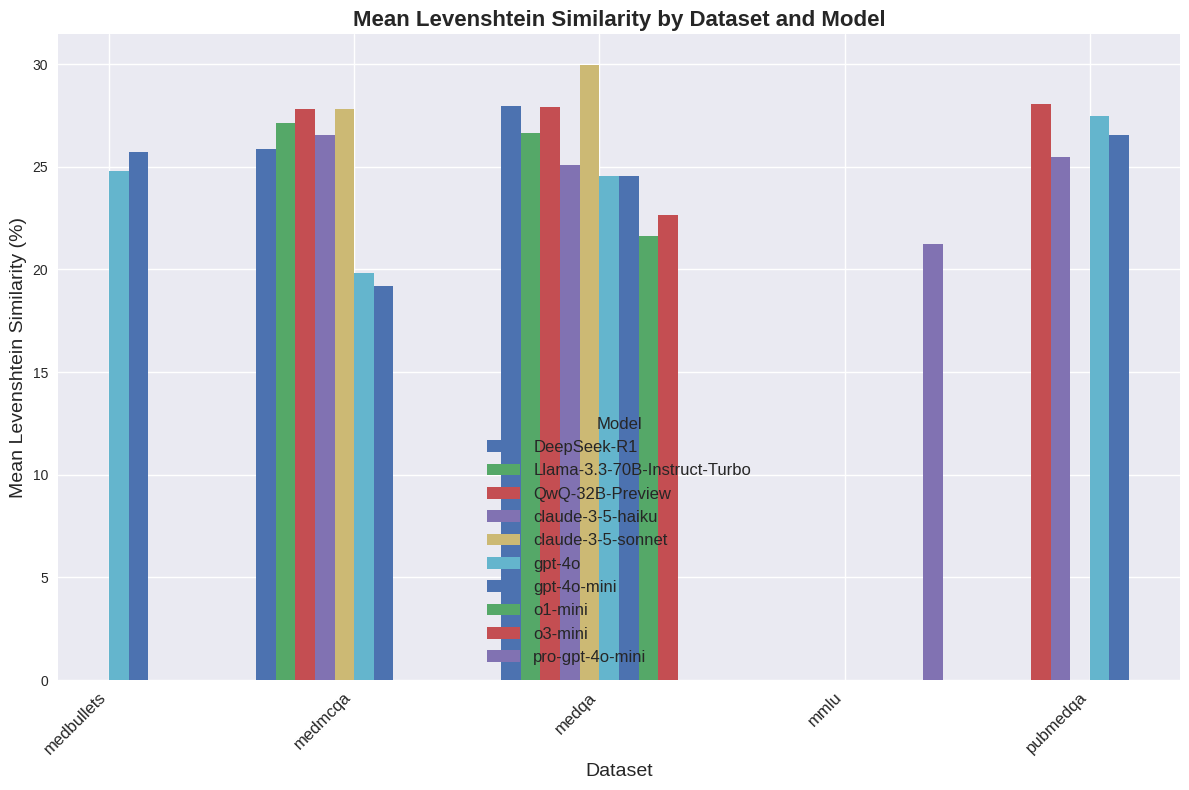

In [15]:
# Calculate Levenshtein distance for each dataset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

lev_distances = defaultdict(list)

for task in tasks:
    for subtask in tasks[task]:
        for model in models:
            try:
                file_path = f'./output/{task}/{model}-{task}-{subtask}-prob.json'
                data = load_json(file_path)
                
                for item in data:
                    if 'q2' in item and 'generated_text' in item:
                        distance = item['levenshtein_distance']
                        ratio = int(round((1 - distance/max(len(item['q2']), len(item['generated_text']))) * 100))
                        lev_distances[f"{task}-{model}"].append(ratio)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

# Create a table of summary statistics
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model-Task", "Mean", "Median", "Std Dev", "Min", "Max"]

for key, distances in lev_distances.items():
    table.add_row([
        key,
        f"{np.mean(distances):.2f}",
        f"{np.median(distances):.2f}", 
        f"{np.std(distances):.2f}",
        f"{np.min(distances):.2f}",
        f"{np.max(distances):.2f}"
    ])

print("\nLevenshtein Similarity Statistics:")
print(table)

try:
    plt.style.use("seaborn-v0_8")
except OSError as e:
    print(f"Warning: {e}. Falling back to the default style.")
    plt.style.use('default')
fig, ax = plt.subplots(figsize=(12, 8))

# Aggregate mean Levenshtein similarities and group by dataset and model
# Assuming lev_distances keys are in "dataset-model" format
dataset_models = {}
for key, values in lev_distances.items():
    if '-' not in key:
        continue
    dataset, model = key.split('-', 1)
    mean_similarity = np.mean(values)
    if dataset not in dataset_models:
        dataset_models[dataset] = {}
    dataset_models[dataset][model] = mean_similarity

# Sort datasets and get the union of all models present
datasets = sorted(dataset_models.keys())
all_models = sorted({model for models_dict in dataset_models.values() for model in models_dict.keys()})

# Define positions for grouped bar plot
n_datasets = len(datasets)
n_models = len(all_models)
bar_width = 0.8 / n_models
x = np.arange(n_datasets)

# Create a grouped bar plot: iterate over models and plot each bar with an offset
for i, model in enumerate(all_models):
    offset = (i - (n_models - 1) / 2) * bar_width  # Center bars within each dataset group
    means = [dataset_models[ds].get(model, np.nan) for ds in datasets]
    ax.bar(x + offset, means, width=bar_width, label=model)

# Set descriptive titles and labels with enhanced font sizes
ax.set_title('Mean Levenshtein Similarity by Dataset and Model', fontsize=16, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=14)
ax.set_ylabel('Mean Levenshtein Similarity (%)', fontsize=14)

# Set x-ticks with dataset labels; rotate labels for clarity
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45, ha='right', fontsize=12)

ax.legend(title="Model", fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.show()


In [3]:
# Create test_hard.json with questions that have low accuracy across models
hard_questions = {}

for task in tasks:
    # Track correct answers per question across all models
    question_correct_counts = {}
    question_total_counts = {}
    
    # First pass - count correct answers for each question
    for model in models:
        for method in methods:
            try:
                file_path = f'./output/{task}/{model}-{task}-test-{method}.json'
                data = load_json(file_path)
                dedup_data = deduplicate_data(data)

                for item in dedup_data:
                    question = item['realidx']
                    if question not in question_correct_counts:
                        question_correct_counts[question] = 0
                        question_total_counts[question] = 0

                    # Increment total count
                    question_total_counts[question] += 1
                    
                    # Check if answer was correct
                    if item['answer_idx'] == item['predicted_answer']:
                        question_correct_counts[question] += 1
                        
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    hard_questions_task = []
    file_path = f'../../data/{task}/test.jsonl'
    data = load_jsonl(file_path)
    for problem in data:
        total_count = question_total_counts[problem['realidx']]
        correct_count = question_correct_counts[problem['realidx']]
        if correct_count / total_count < 0.5:  # Less than 5/10 correct
            hard_questions_task.append(problem)
    
    # Truncate to 100 questions if more than 100
    if len(hard_questions_task) > 100:
        hard_questions_task = hard_questions_task[:100]
    
    if hard_questions_task:
        if task not in hard_questions:
            hard_questions[task] = {}
        hard_questions[task] = hard_questions_task

    save_as_jsonl(hard_questions[task], f'../../data/{task}/test_hard.jsonl')

# Print summary table
summary_table = PrettyTable()
summary_table.field_names = ["Task", "Number of Hard Questions"]

for task in hard_questions:
    num_hard = len(hard_questions[task])
    summary_table.add_row([task, num_hard])

print("\nSummary of Hard Questions (correct < 50% across models):")
print(summary_table)



Summary of Hard Questions (correct < 50% across models):
+------------+--------------------------+
|    Task    | Number of Hard Questions |
+------------+--------------------------+
|   medqa    |           100            |
|  pubmedqa  |           100            |
|  medmcqa   |           100            |
| medbullets |           100            |
|    mmlu    |            73            |
|  mmlu-pro  |           100            |
| afrimedqa  |            52            |
+------------+--------------------------+


: 

Model: o3-mini -> Overall Accuracy: 76.5% | Avg Cost per Sample: $0.0018 | Avg Time per Sample: 6.4988s
Model: gpt-4o-mini -> Overall Accuracy: 55.0% | Avg Cost per Sample: $0.0000 | Avg Time per Sample: 1.0539s
Model: gpt-4o -> Overall Accuracy: 73.4% | Avg Cost per Sample: $0.0005 | Avg Time per Sample: 1.1077s
Model: o1-mini -> Overall Accuracy: 72.9% | Avg Cost per Sample: $0.0019 | Avg Time per Sample: 3.6892s
Model: QwQ-32B-Preview -> Overall Accuracy: 64.4% | Avg Cost per Sample: $0.0006 | Avg Time per Sample: 5.8673s
Model: DeepSeek-R1 -> Overall Accuracy: 79.9% | Avg Cost per Sample: $0.0078 | Avg Time per Sample: 51.5613s
Model: Llama-3.3-70B-Instruct-Turbo -> Overall Accuracy: 66.3% | Avg Cost per Sample: $0.0002 | Avg Time per Sample: 1.0804s
Model: DeepSeek-V3 -> Overall Accuracy: 68.5% | Avg Cost per Sample: $0.0002 | Avg Time per Sample: 1.9205s
Model: claude-3-5-sonnet -> Overall Accuracy: 65.9% | Avg Cost per Sample: $0.0008 | Avg Time per Sample: 1.4644s
Model: claude

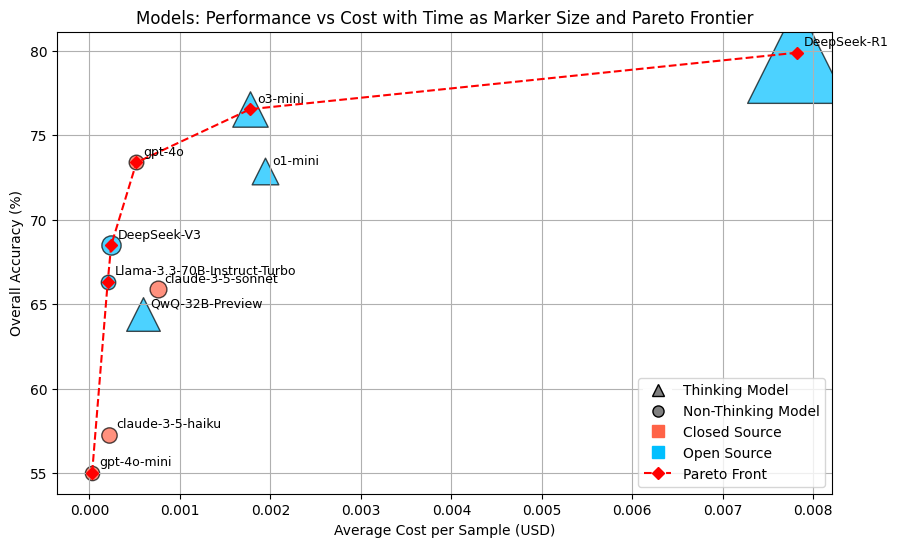

In [6]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Aggregate performance, cost, and time data per model over all experiments
model_stats = {}

for task in tasks:
    for subtask in tasks[task]:
        for model in models:
            for method in methods:
                file_path = f'./output/{task}/{model}-{task}-{subtask}-{method}.json'
                try:
                    data = load_json(file_path)
                    dedup_data = deduplicate_data(data)
                    # calculate_accuracy returns a fraction (0 to 1)
                    acc = calculate_accuracy(dedup_data)
                    total_samples = len(dedup_data)
                    cost_per_sample = calculate_cost_from_token_usage(dedup_data, model)
                    # Get average time per sample from the data
                    avg_time = calculate_time_from_data(dedup_data)
                    # approximate count of correct responses
                    correct = acc * total_samples

                    if model not in model_stats:
                        model_stats[model] = {
                            'total_correct': 0.0,
                            'total_samples': 0,
                            'total_cost': 0.0,
                            'total_time': 0.0
                        }

                    model_stats[model]['total_correct'] += correct
                    model_stats[model]['total_samples'] += total_samples
                    model_stats[model]['total_cost'] += cost_per_sample * total_samples
                    # Multiply avg_time by the number of samples to later compute a weighted average
                    model_stats[model]['total_time'] += avg_time * total_samples
                except Exception as e:
                    print(f"Skipping {file_path}: {e}")

# Prepare lists with aggregated overall accuracy, average cost, and average time per sample for each model.
model_names = []
avg_accuracies = []  # as fraction
avg_costs = []       # in USD per sample
avg_times = []       # in seconds per sample

for model, stats in model_stats.items():
    if stats['total_samples'] > 0:
        overall_acc = stats['total_correct'] / stats['total_samples']  # weighted accuracy
        avg_cost = stats['total_cost'] / stats['total_samples']
        overall_time = stats['total_time'] / stats['total_samples']
        model_names.append(model)
        avg_accuracies.append(overall_acc)
        avg_costs.append(avg_cost)
        avg_times.append(overall_time)
        print(f"Model: {model} -> Overall Accuracy: {overall_acc*100:.1f}% | Avg Cost per Sample: ${avg_cost:.4f} | Avg Time per Sample: {overall_time:.4f}s")
    else:
        print(f"Model: {model} had no processed samples.")

# Compute Pareto frontier among models.
# A model is not Pareto-dominated if no other model has lower (or equal) cost and higher (or equal) accuracy with at least one strict improvement.
points = list(zip(avg_costs, avg_accuracies))
pareto_indices = []
for i, (cost, acc) in enumerate(points):
    dominated = False
    for j, (other_cost, other_acc) in enumerate(points):
        if i == j:
            continue
        if (other_cost <= cost and other_acc >= acc) and ((other_cost < cost) or (other_acc > acc)):
            dominated = True
            break
    if not dominated:
        pareto_indices.append(i)

# Sort Pareto frontier points by cost for a clean overlay.
pareto_points = sorted([(avg_costs[i], avg_accuracies[i], model_names[i]) for i in pareto_indices], key=lambda x: x[0])
pareto_costs = [pt[0] for pt in pareto_points]
pareto_accs = [pt[1]*100 for pt in pareto_points]  # converting to percentage

# Plot all models with customized markers and sizes (using avg_time) to reflect additional dimensions.
plt.figure(figsize=(10, 6))

# Define a scale factor for marker size (adjusted to make the markers smaller)
size_scale = 100

for i, model in enumerate(model_names):
    cost = avg_costs[i]
    acc_percent = avg_accuracies[i] * 100
    time_val = avg_times[i]
    marker_size = time_val * size_scale

    # Determine if the model is a "thinking" model based on keywords.
    lower_model = model.lower()
    is_thinking = any(kw in lower_model for kw in ['r1', 'qwq', 'o1-mini', 'o3-mini'])
    # Determine open source vs closed source: consider models with 'gpt' or 'claude' as closed source.
    is_closed = ('gpt' in lower_model or 'claude' in lower_model)

    # Set marker shape: thinking models get a triangle, non-thinking get a circle.
    marker = '^' if is_thinking else 'o'
    # Set color based on open vs closed source.
    color = 'tomato' if is_closed else 'deepskyblue'

    plt.scatter(cost, acc_percent, s=marker_size, marker=marker, color=color, alpha=0.7, edgecolors='k')
    plt.annotate(model, (cost, acc_percent), textcoords="offset points", xytext=(5, 5), fontsize=9)

# Overlay the Pareto frontier.
plt.plot(pareto_costs, pareto_accs, color='red', linestyle='--', marker='D', markersize=6, label='Pareto Front')

plt.xlabel("Average Cost per Sample (USD)")
plt.ylabel("Overall Accuracy (%)")
plt.title("Models: Performance vs Cost with Time as Marker Size and Pareto Frontier")
plt.grid(True)

# Create a custom legend to explain marker shape and color.
legend_elements = [
    Line2D([0], [0], marker='^', color='w', label='Thinking Model', markerfacecolor='gray', markersize=8, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='Non-Thinking Model', markerfacecolor='gray', markersize=8, markeredgecolor='k'),
    Line2D([0], [0], marker='s', color='tomato', label='Closed Source', markersize=8, linestyle='None'),
    Line2D([0], [0], marker='s', color='deepskyblue', label='Open Source', markersize=8, linestyle='None'),
    Line2D([0], [0], marker='D', color='red', label='Pareto Front', markersize=6, linestyle='--')
]
plt.legend(handles=legend_elements, loc='best')

plt.show()


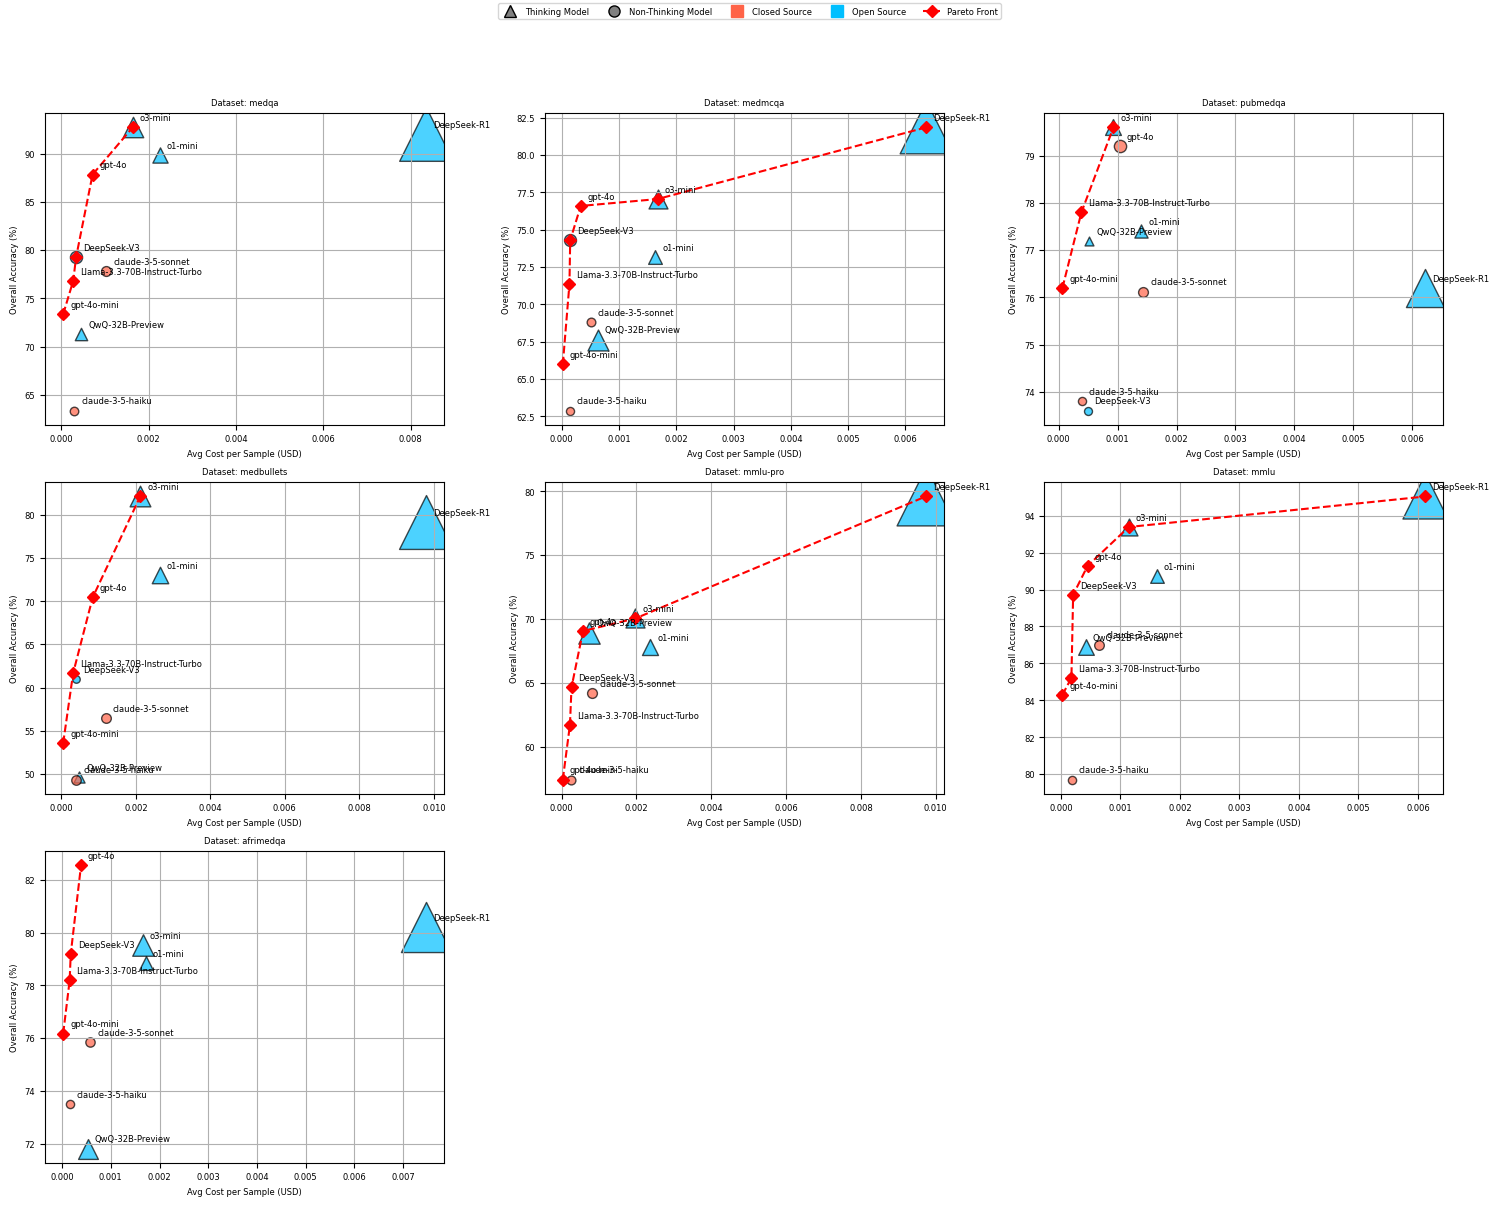

In [18]:
import os
import json
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

datasets = ['medqa', 'medmcqa', 'pubmedqa', 'medbullets', 'mmlu-pro', 'mmlu', 'afrimedqa']
# Create subplots to show dataset-specific performance vs. cost in one figure.
ncols = 3
nrows = math.ceil(len(datasets) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    dataset_stats = {}  # To store aggregated stats per model for this dataset

    for model in model_names:
        model_filename = model.replace('/', '_')
        file_path = os.path.join('.', 'output', dataset, f"{model_filename}-{dataset}-test-zero_shot.json")
        
        if not os.path.exists(file_path):
            print(f"JSON file not found for model '{model}' in dataset '{dataset}': {file_path}")
            continue
        
        with open(file_path, 'r') as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from {file_path}: {e}")
                continue
        
        # Optionally deduplicate data if applicable.
        dedup_data = deduplicate_data(data)
        total_samples = len(dedup_data)
        if total_samples == 0:
            continue
        
        # Compute performance metrics.
        acc = calculate_accuracy(dedup_data)  # returns a fraction between 0 and 1
        cost_per_sample = calculate_cost_from_token_usage(dedup_data, model)
        avg_time = calculate_time_from_data(dedup_data)
        correct = acc * total_samples
        
        dataset_stats[model] = {
            'total_correct': correct,
            'total_samples': total_samples,
            'total_cost': cost_per_sample * total_samples,
            'total_time': avg_time * total_samples
        }
    
    # Prepare lists for plotting for this dataset.
    ds_model_names = []
    ds_avg_accuracies = []   # as fraction
    ds_avg_costs = []        # in USD per sample
    ds_avg_times = []        # in seconds per sample
    
    for model, stats in dataset_stats.items():
        if stats['total_samples'] > 0:
            overall_acc = stats['total_correct'] / stats['total_samples']
            avg_cost = stats['total_cost'] / stats['total_samples']
            overall_time = stats['total_time'] / stats['total_samples']
            ds_model_names.append(model)
            ds_avg_accuracies.append(overall_acc)
            ds_avg_costs.append(avg_cost)
            ds_avg_times.append(overall_time)
    
    # Compute the Pareto frontier for the dataset.
    ds_points = list(zip(ds_avg_costs, ds_avg_accuracies))
    ds_pareto_indices = []
    for i, (cost, acc) in enumerate(ds_points):
        dominated = False
        for j, (other_cost, other_acc) in enumerate(ds_points):
            if i == j:
                continue
            if (other_cost <= cost and other_acc >= acc) and ((other_cost < cost) or (other_acc > acc)):
                dominated = True
                break
        if not dominated:
            ds_pareto_indices.append(i)
    
    ds_pareto_points = sorted(
        [(ds_avg_costs[i], ds_avg_accuracies[i], ds_model_names[i]) for i in ds_pareto_indices],
        key=lambda x: x[0]
    )
    ds_pareto_costs = [pt[0] for pt in ds_pareto_points]
    ds_pareto_accs = [pt[1] * 100 for pt in ds_pareto_points]  # Convert accuracy to percentage
    
    # Plot dataset-specific model points.
    size_scale = 30  # Adjust marker size scale if needed
    for i, model in enumerate(ds_model_names):
        cost = ds_avg_costs[i]
        acc_percent = ds_avg_accuracies[i] * 100
        time_val = ds_avg_times[i]
        marker_size = time_val * size_scale
        
        lower_model = model.lower()
        # Determine marker shape: thinking models get a triangle.
        is_thinking = any(kw in lower_model for kw in ['r1', 'qwq', 'o1-mini', 'o3-mini'])
        marker = '^' if is_thinking else 'o'
        # Determine color based on open vs closed source.
        is_closed = ('gpt' in lower_model or 'claude' in lower_model)
        color = 'tomato' if is_closed else 'deepskyblue'
        
        ax.scatter(cost, acc_percent, s=marker_size, marker=marker, color=color, alpha=0.7, edgecolors='k')
        ax.annotate(model, (cost, acc_percent), textcoords="offset points", xytext=(5, 5), fontsize=6)
    
    # Overlay the Pareto frontier.
    ax.plot(ds_pareto_costs, ds_pareto_accs, color='red', linestyle='--', marker='D', markersize=6)
    ax.set_title(f"Dataset: {dataset}", fontsize=6)
    ax.set_xlabel("Avg Cost per Sample (USD)", fontsize=6)
    ax.set_ylabel("Overall Accuracy (%)", fontsize=6)
    ax.grid(True)

# Disable any extra subplots if the grid is larger than the number of datasets.
for j in range(len(datasets), len(axes)):
    axes[j].axis('off')

# Create one unified legend for all subplots.
legend_elements = [
    Line2D([0], [0], marker='^', color='w', label='Thinking Model', markerfacecolor='gray', markersize=8, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='Non-Thinking Model', markerfacecolor='gray', markersize=8, markeredgecolor='k'),
    Line2D([0], [0], marker='s', color='tomato', label='Closed Source', markersize=8, linestyle='None'),
    Line2D([0], [0], marker='s', color='deepskyblue', label='Open Source', markersize=8, linestyle='None'),
    Line2D([0], [0], marker='D', color='red', label='Pareto Front', markersize=6, linestyle='--')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=5, fontsize=6)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


Processing dataset 'medqa' with 10 model file(s).
Processing dataset 'medmcqa' with 10 model file(s).
Processing dataset 'pubmedqa' with 10 model file(s).
Processing dataset 'medbullets' with 10 model file(s).
Processing dataset 'mmlu-pro' with 10 model file(s).
Processing dataset 'mmlu' with 10 model file(s).
Processing dataset 'afrimedqa' with 10 model file(s).


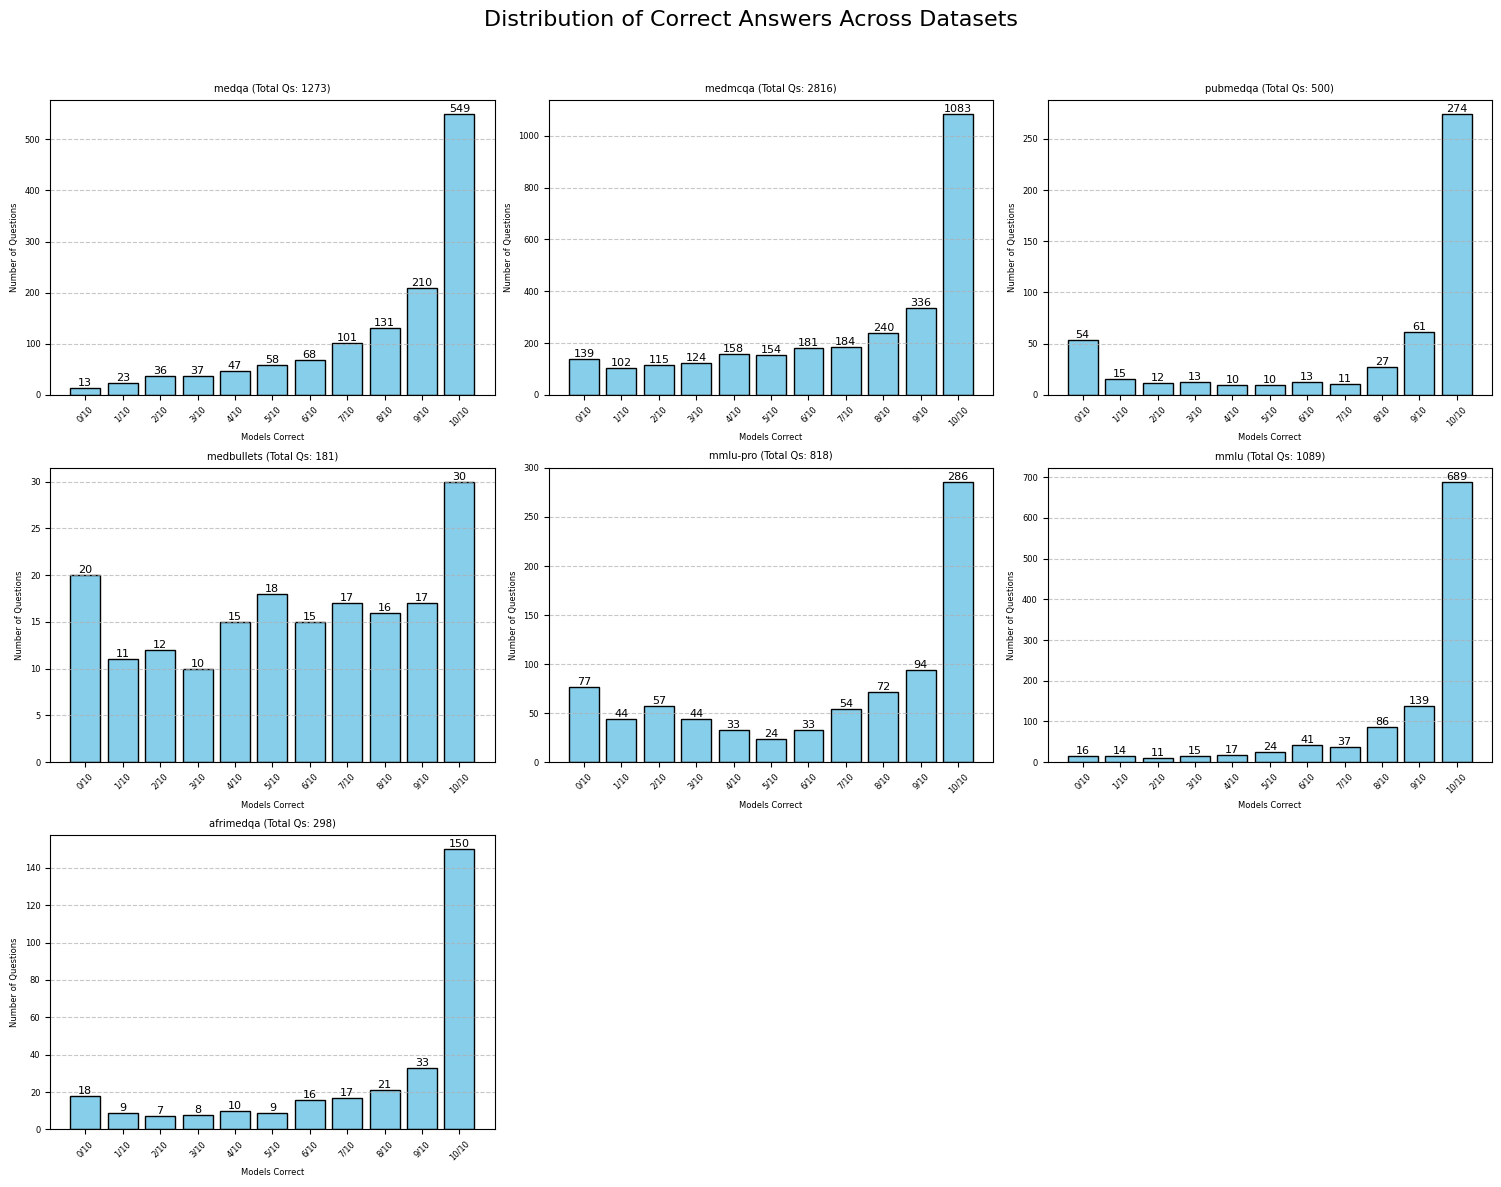

In [17]:
import os
import json
import math
import matplotlib.pyplot as plt
from collections import Counter

# Assume that both 'datasets' and 'model_names' are defined previously.
datasets = ['medqa', 'medmcqa', 'pubmedqa', 'medbullets', 'mmlu-pro', 'mmlu', 'afrimedqa']
# model_names is assumed to be defined earlier (e.g., model_names = ['claude-3-5-haiku', 'claude-3-5-sonnet', ...])

# Determine subplot grid dimensions (using 3 columns for a balanced layout)
n_datasets = len(datasets)
ncols = 3
nrows = math.ceil(n_datasets / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

for ax, dataset in zip(axes, datasets):
    print(f"Processing dataset '{dataset}' with {len(model_names)} model file(s).")
    
    # Aggregate the count of models that answered each question correctly.
    # Use the question's unique identifier ("realidx") if available; otherwise, fallback to "question" text.
    question_correct = {}  # key: question identifier; value: count of correct responses across models
    
    for model in model_names:
        # Convert model name to a file-friendly format.
        model_filename = model.replace('/', '_')
        # Construct the expected JSON filename.
        file_path = os.path.join('.', 'output', dataset, f"{model_filename}-{dataset}-test-zero_shot.json")
        
        if not os.path.exists(file_path):
            print(f"JSON file not found for model '{model}' in dataset '{dataset}' with expected filename: {file_path}")
            continue
        
        with open(file_path, 'r') as f:
            try:
                predictions = json.load(f)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from {file_path}: {e}")
                continue
        
        for entry in predictions:
            # Use "realidx" as unique identifier if provided; otherwise, fallback to the "question" text.
            qid = entry.get("realidx") or entry.get("question", "unknown_question")
            # Determine whether the model's answer is correct.
            predicted = str(entry.get("predicted_answer", "")).strip()
            correct_ans = str(entry.get("answer_idx", "")).strip()
            # Initialize count for this question if not already present.
            if qid not in question_correct:
                question_correct[qid] = 0
            if predicted == correct_ans:
                question_correct[qid] += 1

    # Assume the total number of models equals the length of model_names.
    total_models = len(model_names)
    
    # Compute the distribution: count how many questions received k correct answers (k = 0, 1, ..., total_models).
    distribution = Counter(question_correct.values())
    
    # Prepare data for plotting: ensure counts for all possible correct responses are present.
    x_values = list(range(total_models + 1))
    y_counts = [distribution.get(k, 0) for k in x_values]
    x_labels = [f"{k}/{total_models}" for k in x_values]

    # Create a bar plot in the corresponding subplot axis.
    bars = ax.bar(x_values, y_counts, color='skyblue', edgecolor='black')
    ax.set_xlabel("Models Correct")
    ax.set_ylabel("Number of Questions")
    ax.set_title(f"{dataset} (Total Qs: {sum(y_counts)})")
    ax.set_xticks(x_values)
    ax.set_xticklabels(x_labels, rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Annotate each bar with its count value for added clarity.
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=8)

# Hide any unused subplots.
for ax in axes[n_datasets:]:
    ax.axis('off')

fig.suptitle("Distribution of Correct Answers Across Datasets", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [2]:
import glob
import shutil
import os

# Define the pattern to match all JSON files with "test_hard" in their filename under the output directory.
pattern = os.path.join('.', 'output', '*', '*test_hard*.json')
files = glob.glob(pattern, recursive=True)
print(f"Found {len(files)} file(s) matching pattern: {pattern}")

for file_path in files:
    # Generate new filenames by replacing "test_hard" with "test" and "test_good"
    new_file_test = file_path.replace("test_hard", "test")
    new_file_test_good = file_path.replace("test_hard", "test_good")

    # Copy the original file to the new file for "test"
    shutil.copy(file_path, new_file_test)

    # Copy the original file to the new file for "test_good"
    shutil.copy(file_path, new_file_test_good)

    print(f"Copied {file_path} to {new_file_test} and {new_file_test_good}")

Found 28 file(s) matching pattern: ./output/*/*test_hard*.json
Copied ./output/mmlu-pro/o3-mini-mmlu-pro-test_hard-zero_shot.json to ./output/mmlu-pro/o3-mini-mmlu-pro-test-zero_shot.json and ./output/mmlu-pro/o3-mini-mmlu-pro-test_good-zero_shot.json
Copied ./output/mmlu-pro/gpt-4o-mini-mmlu-pro-test_hard-zero_shot.json to ./output/mmlu-pro/gpt-4o-mini-mmlu-pro-test-zero_shot.json and ./output/mmlu-pro/gpt-4o-mini-mmlu-pro-test_good-zero_shot.json
Copied ./output/mmlu-pro/gpt-4o-mmlu-pro-test_hard-zero_shot.json to ./output/mmlu-pro/gpt-4o-mmlu-pro-test-zero_shot.json and ./output/mmlu-pro/gpt-4o-mmlu-pro-test_good-zero_shot.json
Copied ./output/mmlu-pro/o1-mini-mmlu-pro-test_hard-zero_shot.json to ./output/mmlu-pro/o1-mini-mmlu-pro-test-zero_shot.json and ./output/mmlu-pro/o1-mini-mmlu-pro-test_good-zero_shot.json
Copied ./output/pubmedqa/gpt-4o-mini-pubmedqa-test_hard-zero_shot.json to ./output/pubmedqa/gpt-4o-mini-pubmedqa-test-zero_shot.json and ./output/pubmedqa/gpt-4o-mini-pubme